# Introduction to Image Super Resolution

This notebook demonstrates how to use deep learning to improve the resolution of images using the LAB color space. The workflow includes data preparation, model definition, training with progress visualization, and evaluation.

## Configuration

Define the settings that will be used for the super-resolution experiment

In [1]:
# Configuration for training
config = {
    "batch_size": 16,  # A batch is a set of images processed together by the model
    "adam_lr": 1e-3,  # The learning rate for the Adam optimizer sets how quickly the model learns (too quick can lead to instability)
    "loss_type": "mse",  # or 'lpips' # The loss function measures how well the model's predictions match the ground truth (mse is mean squared error, lpips is perceptual loss)
    "resume_weights_path": None,  # Path to checkpoint to resume from
    "num_epochs": 10,
    "train_batches_per_epoch": 64,
    "validation_batches_per_epoch": 16,
}

## Import Required Libraries
Import all necessary libraries for deep learning, image processing, visualization, and progress tracking.

In [2]:
import warnings
from pathlib import Path
from io import BytesIO
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, IterableDataset
from torchvision import transforms
from skimage import color
from datasets import load_dataset
from PIL import Image
import lpips
from torchinfo import summary
from tqdm import tqdm

## Why Use the LAB Color Space?
The LAB color space separates the lightness (L) from the color information (A and B channels). This helps our model focus on making the image brighter and clearer, while keeping the colors accurate.

In [3]:
def to_lab_tensor(img: Image.Image) -> torch.Tensor:
    arr = np.asarray(img.convert("RGB"), dtype=np.float32) / 255.0
    lab = color.rgb2lab(arr)
    l_channel = lab[..., 0:1] / 100.0
    a = lab[..., 1:2] / 128.0
    b = lab[..., 2:3] / 128.0
    lab_norm = np.concatenate([l_channel, a, b], axis=-1)
    return torch.from_numpy(lab_norm.transpose(2, 0, 1).copy()).float()


def to_numpy_img(lab_tensor: torch.Tensor) -> np.ndarray:
    arr = lab_tensor.detach().cpu().numpy().transpose(1, 2, 0)
    l_channel = arr[..., 0] * 100.0
    a = arr[..., 1] * 128.0
    b = arr[..., 2] * 128.0
    lab = np.stack([l_channel, a, b], axis=-1)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        rgb = color.lab2rgb(lab)
    return np.clip(rgb, 0, 1)

## Preparing the Dataset
Prepare the dataset by cropping, resizing, and converting images to LAB format. Define a streaming dataset class for efficient loading.

In [4]:
def preprocess_stream(dataset, crop_size: int, scale: int):
    lowres_size = crop_size // scale
    crop = transforms.RandomCrop(crop_size)
    for example in dataset:
        img_data = example["image"]
        img = (
            img_data
            if isinstance(img_data, Image.Image)
            else Image.open(BytesIO(img_data)).convert("RGB")
        )
        if min(img.size) < crop_size:
            scale_factor = crop_size / min(img.size)
            new_size = (
                int(round(img.size[0] * scale_factor)),
                int(round(img.size[1] * scale_factor)),
            )
            img = img.resize(new_size, resample=Image.Resampling.BICUBIC)
        img_patch = crop(img)
        lab_patch = to_lab_tensor(img_patch)
        lab_patch_lowres = torch.nn.functional.interpolate(
            lab_patch.unsqueeze(0),
            size=(lowres_size, lowres_size),
            mode="bicubic",
            align_corners=False,
        ).squeeze(0)
        yield lab_patch_lowres, lab_patch


class SuperResStream(IterableDataset):
    def __init__(self, dataset, crop_size: int, scale: int):
        self.dataset = dataset
        self.crop_size = crop_size
        self.scale = scale

    def __iter__(self):
        return preprocess_stream(self.dataset, self.crop_size, self.scale)

## Load Datasets
Load the training and validation datasets using Hugging Face Datasets in streaming mode.

In [5]:
train_dataset = load_dataset(
    "imagenet-1k",
    split="train",
    streaming=True,
    trust_remote_code=True,
)
val_dataset = load_dataset(
    "imagenet-1k",
    split="validation",
    streaming=True,
    trust_remote_code=True,
)

In [6]:
crop_size = 128
scale = 2
train_stream = SuperResStream(train_dataset, crop_size, scale)
val_stream = SuperResStream(val_dataset, crop_size, scale)

In [7]:
train_loader = DataLoader(
    train_stream,
    batch_size=config["batch_size"],
    num_workers=0,
    pin_memory=True,
)
val_loader = DataLoader(
    val_stream,
    batch_size=config["batch_size"],
    num_workers=0,
    pin_memory=True,
)

## Build the Deep Super-Resolution Model
Define the deep neural network for super-resolution, focusing on the L (lightness) channel.

In [8]:
class DeepSuperResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.head = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        body_layers = []
        for _ in range(8):
            body_layers.append(nn.Conv2d(128, 128, kernel_size=3, padding=1))
            body_layers.append(nn.ReLU(inplace=True))
        self.body = nn.Sequential(*body_layers)
        self.upsample = nn.Sequential(
            nn.Conv2d(128, 512, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 512, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.ReLU(inplace=True),
        )
        self.tail = nn.Conv2d(
            128,
            1,
            kernel_size=3,
            padding=1,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.head(x)
        x = self.body(x)
        x = self.upsample(x)
        x = self.tail(x)
        return x

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepSuperResNet().to(device)
print("Model summary:")
print(
    summary(
        model,
        input_size=(config["batch_size"], 3, 64, 64),
        col_names=("input_size", "output_size", "num_params"),
        depth=4,
        row_settings=("var_names",),
    )
)
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Model summary:
Layer (type (var_name))                  Input Shape               Output Shape              Param #
DeepSuperResNet (DeepSuperResNet)        [16, 3, 64, 64]           [16, 1, 256, 256]         --
├─Sequential (head)                      [16, 3, 64, 64]           [16, 128, 64, 64]         --
│    └─Conv2d (0)                        [16, 3, 64, 64]           [16, 64, 64, 64]          9,472
│    └─ReLU (1)                          [16, 64, 64, 64]          [16, 64, 64, 64]          --
│    └─Conv2d (2)                        [16, 64, 64, 64]          [16, 128, 64, 64]         73,856
│    └─ReLU (3)                          [16, 128, 64, 64]         [16, 128, 64, 64]         --
├─Sequential (body)                      [16, 128, 64, 64]         [16, 128, 64, 64]         --
│    └─Conv2d (0)                        [16, 128, 64, 64]         [16, 128, 64, 64]         147,584
│    └─ReLU (1)                          [16, 128, 64, 64]         [16, 128, 64, 64]         --
│    └─C

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.get("adam_lr", 1e-3))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=5,
    min_lr=1e-7,
)

In [11]:
if config["loss_type"] == "lpips":
    lpips_loss_fn = lpips.LPIPS(net="vgg", spatial=False).to(device)

    def criterion(pred, target):
        pred = 2 * pred - 1
        target = 2 * target - 1
        return lpips_loss_fn(pred, target).mean()
elif config["loss_type"] == "mse":
    mse_loss_fn = nn.MSELoss()

    def criterion(pred, target):
        return mse_loss_fn(pred, target)
else:
    raise ValueError(f"Unknown loss_type: {config['loss_type']}")

## Visualize Progress
Let's visualize the results of the last batch from both training and validation.

In [12]:
def visualize_progress(model, lowres, highres, device, title="Output", save_path=None):
    model.eval()
    with torch.no_grad():
        lowres_AB = lowres[:, 1:3]
        highres_L = highres[:, 0:1]
        upsampled = torch.nn.functional.interpolate(
            lowres,
            size=highres.shape[-2:],
            mode="bicubic",
            align_corners=False,
        )
        pred_L = model(upsampled.to(device)).cpu()
        up_AB = torch.nn.functional.interpolate(
            lowres_AB,
            size=highres_L.shape[-2:],
            mode="bilinear",
            align_corners=False,
        )
        if pred_L.shape[-2:] != up_AB.shape[-2:]:
            pred_L = torch.nn.functional.interpolate(
                pred_L,
                size=up_AB.shape[-2:],
                mode="bicubic",
                align_corners=False,
            )
        outputs = torch.cat([pred_L, up_AB], dim=1)
        n = min(6, lowres.size(0))
        fig, axes = plt.subplots(3, n, figsize=(2.5 * n, 8))
        for i in range(n):
            axes[0, i].imshow(to_numpy_img(lowres[i]))
            axes[0, i].set_title("Low-res", fontsize=10)
            axes[1, i].imshow(to_numpy_img(outputs[i]))
            axes[1, i].set_title("Output", fontsize=10)
            axes[2, i].imshow(to_numpy_img(highres[i]))
            axes[2, i].set_title("High-res", fontsize=10)
            for row in range(3):
                axes[row, i].axis("off")
        plt.suptitle(title)
        plt.tight_layout()
        if save_path is not None:
            plt.savefig(save_path)
        plt.show()


def plot_loss_curves(train_losses, val_losses, save_path):
    plt.figure(figsize=(8, 5))
    plt.plot(
        range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker="o"
    )
    plt.plot(
        range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o"
    )
    plt.semilogy()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()


output_dir = Path("results")
output_dir.mkdir(exist_ok=True)

## Training Loop: One Epoch
Let's run one epoch of training. We'll process a set number of batches, update the model, and keep track of the loss.

Epoch 1/10 - avg train loss: 0.2258 | avg val loss: 0.0343


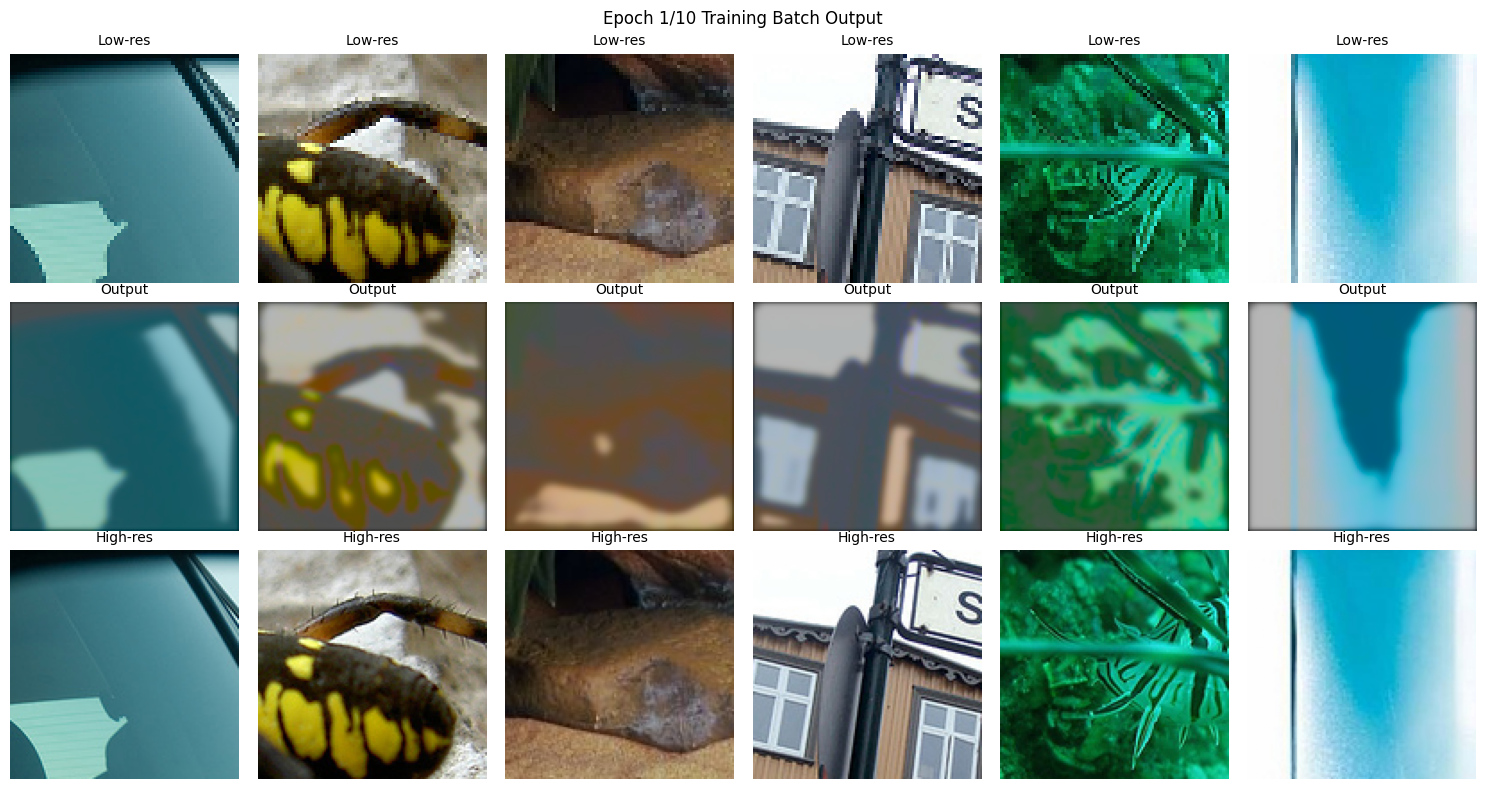

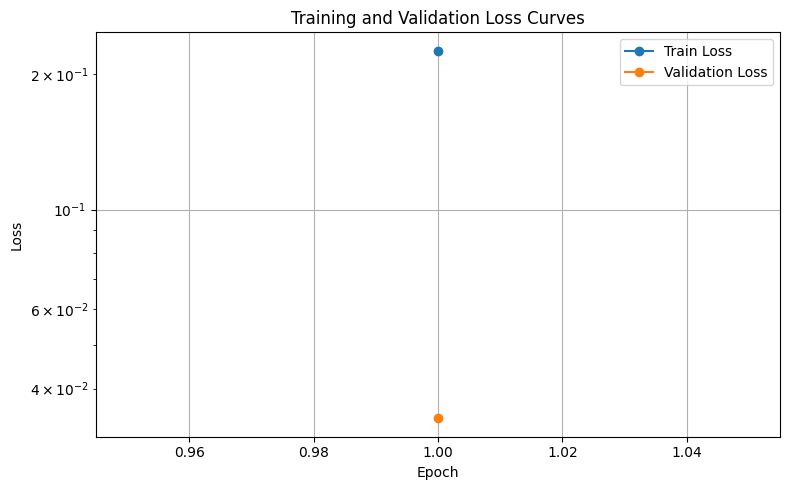

Epoch 2/10 - avg train loss: 0.0132 | avg val loss: 0.0083


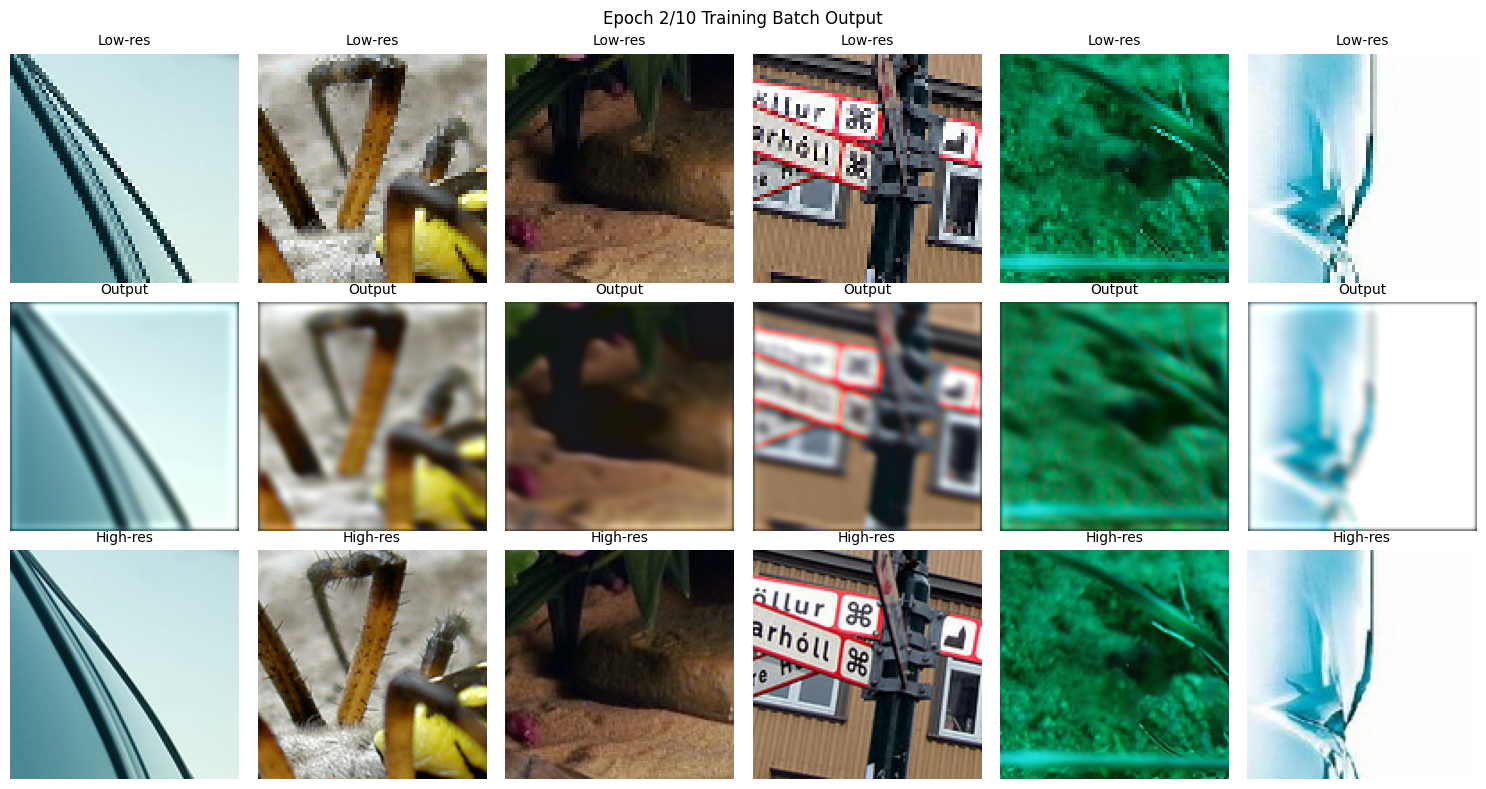

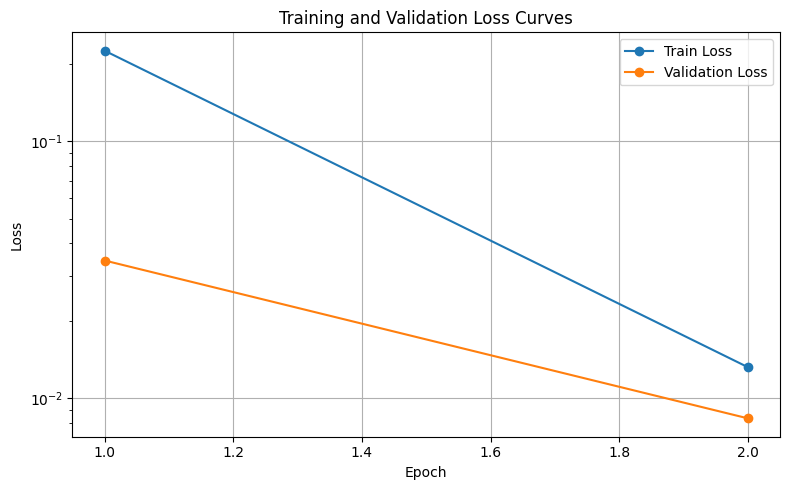

Epoch 3/10 - avg train loss: 0.0065 | avg val loss: 0.0063


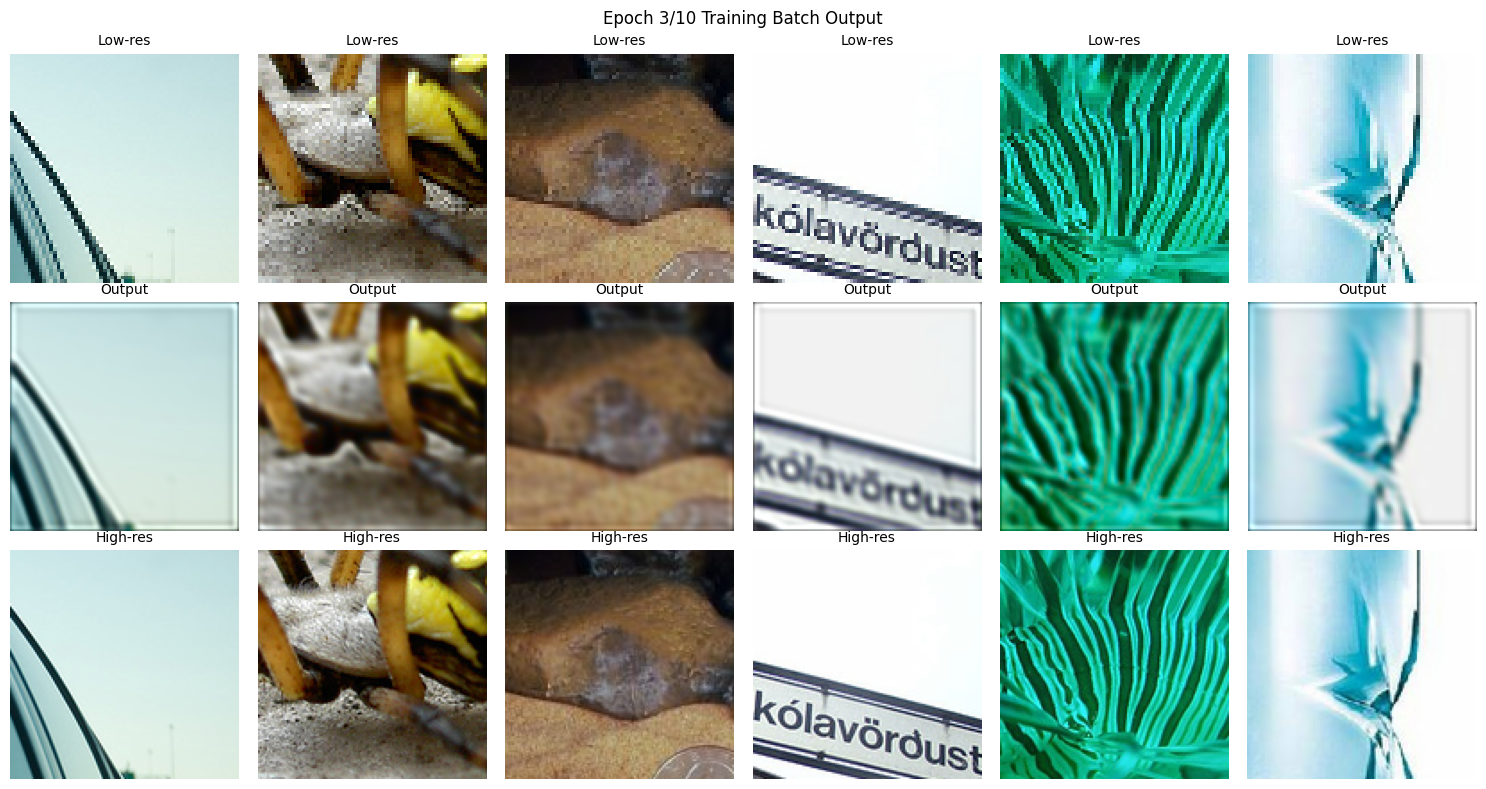

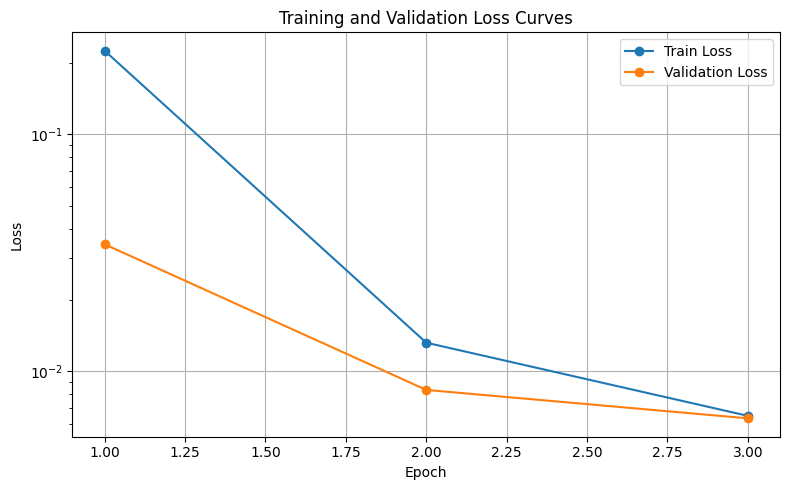

Epoch 4/10 - avg train loss: 0.0053 | avg val loss: 0.0048


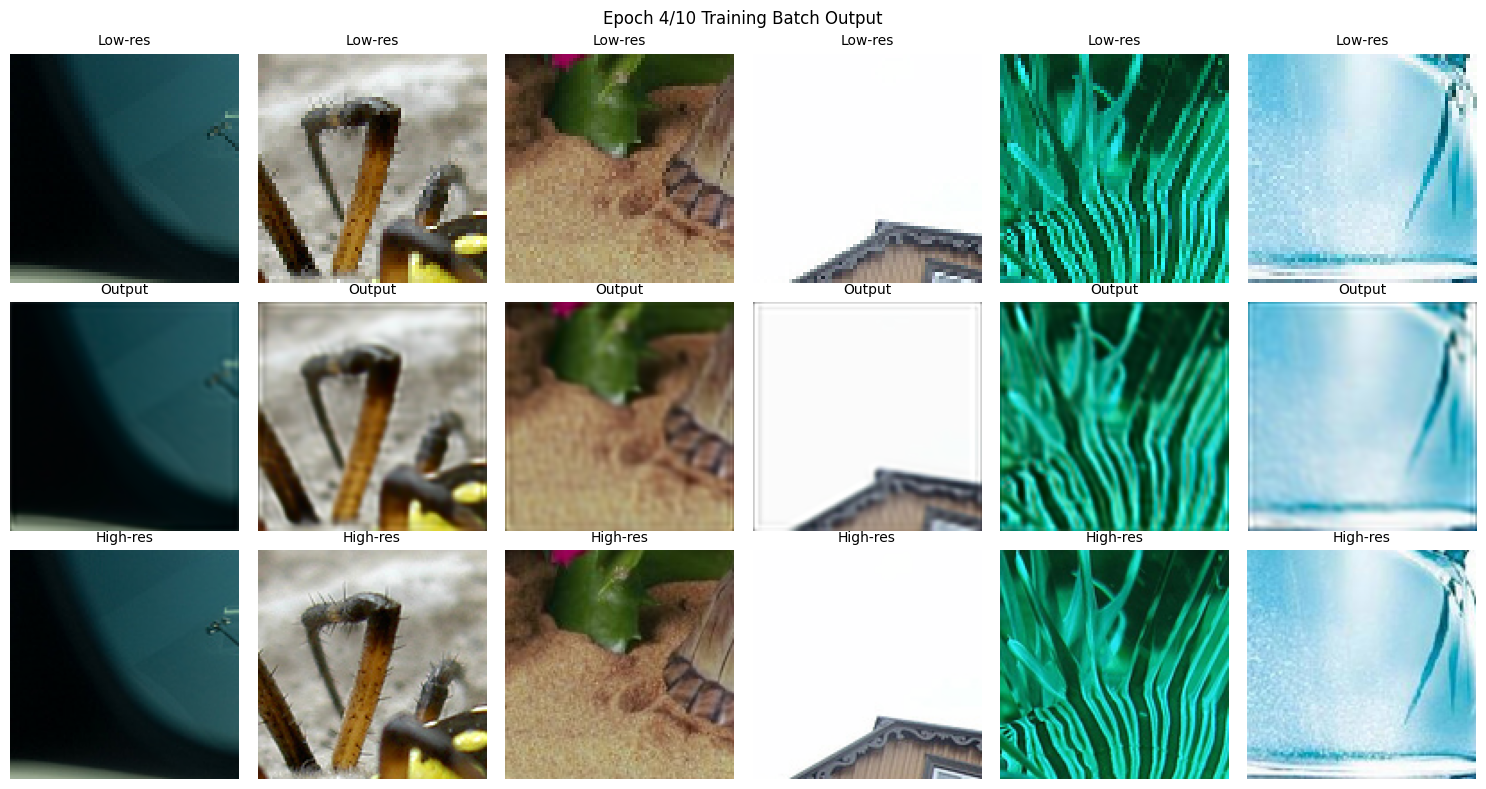

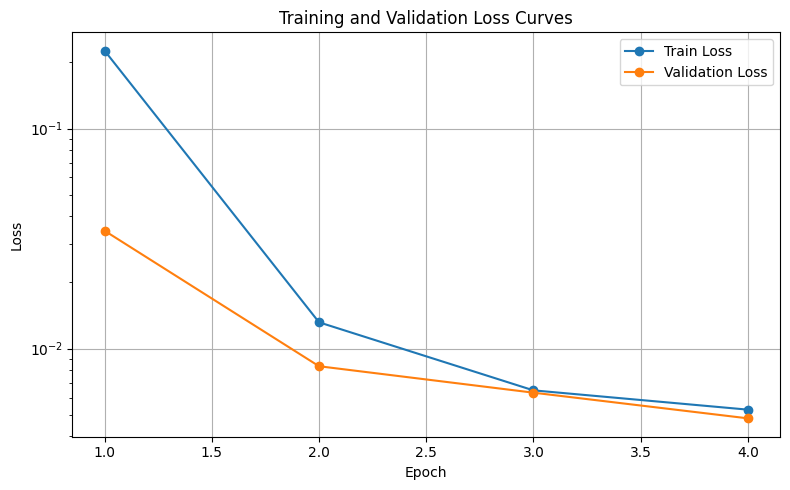

Epoch 5/10 - avg train loss: 0.0039 | avg val loss: 0.0035


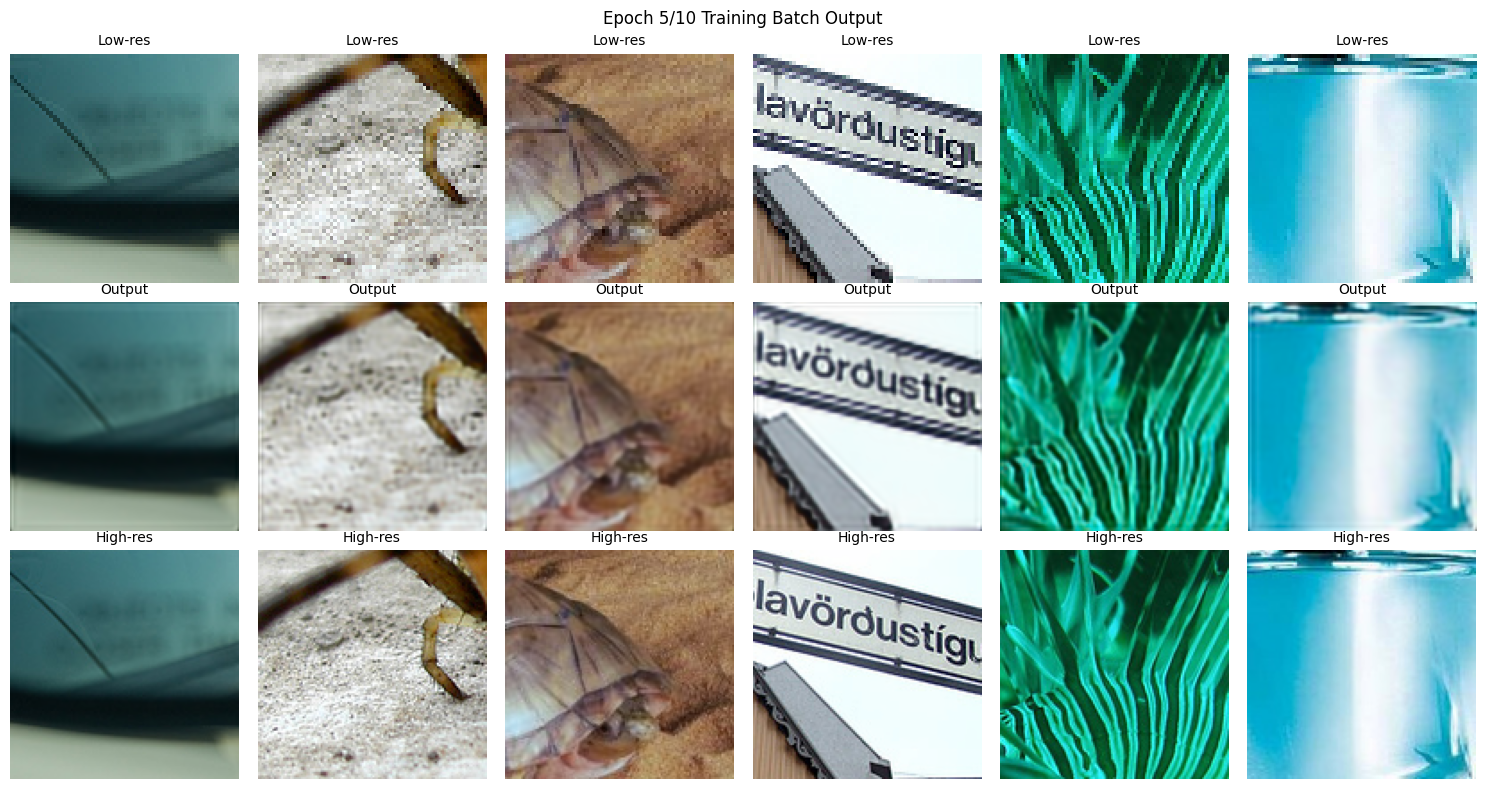

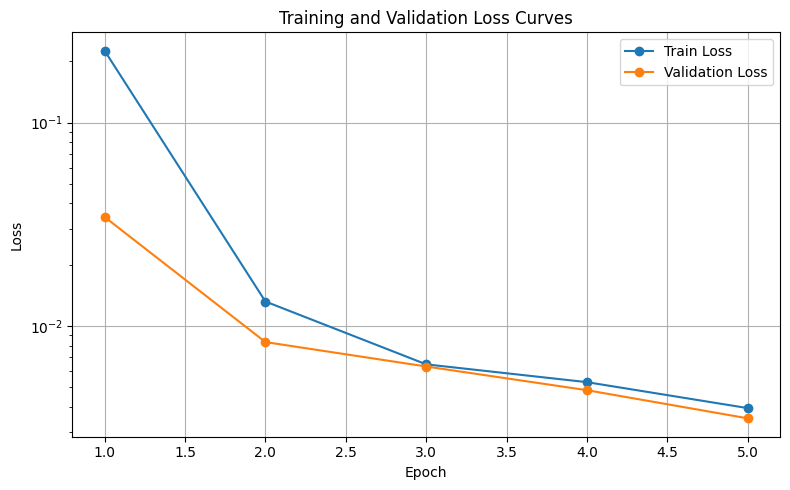

Epoch 6/10 - avg train loss: 0.0037 | avg val loss: 0.0042


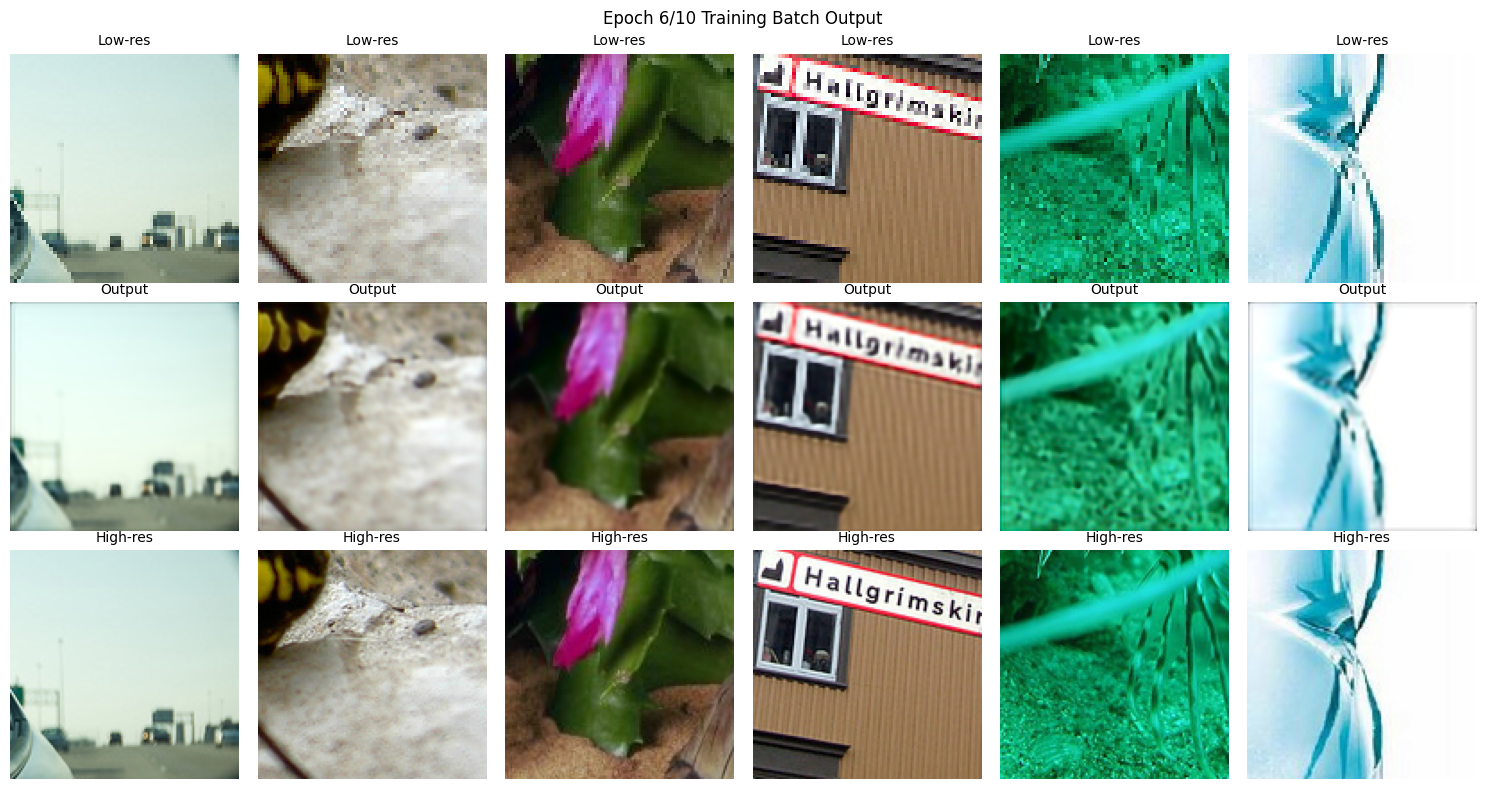

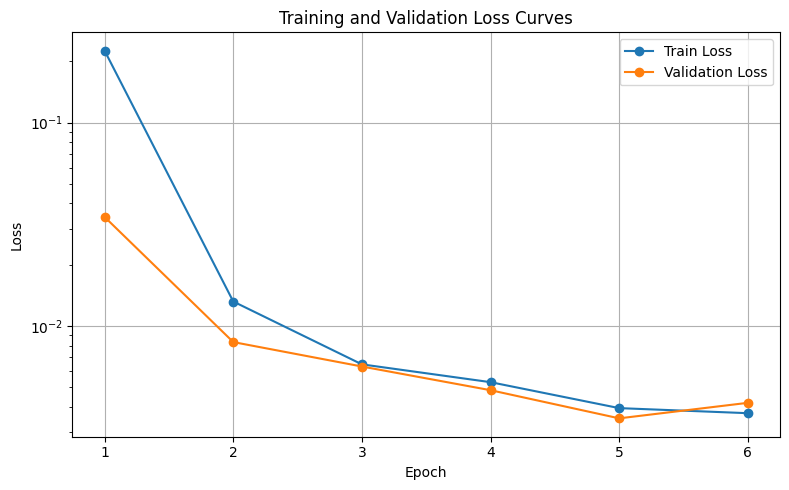

Epoch 7/10 Training:  78%|█████████████████████████████████████████████████▏             | 50/64 [00:44<00:11,  1.23it/s, loss=0.0029]

In [ ]:
train_losses = []
val_losses = []
for epoch in range(config["num_epochs"]):
    prefix = f"Epoch {epoch+1}/{config['num_epochs']}"
    model.train()
    running_loss, batch_count = 0.0, 0
    train_iterator = iter(train_loader)
    last_lowres, last_highres = None, None
    train_bar = tqdm(
        range(config["train_batches_per_epoch"]), desc=f"{prefix} Training", leave=False
    )
    for _ in train_bar:
        try:
            lowres, highres = next(train_iterator)
        except StopIteration:
            train_iterator = iter(train_loader)
            lowres, highres = next(train_iterator)
        lowres = lowres.to(device)
        highres = highres.to(device)
        upsampled = torch.nn.functional.interpolate(
            lowres,
            size=highres.shape[-2:],
            mode="bicubic",
            align_corners=False,
        )
        output_L = model(upsampled)
        highres_L = highres[:, 0:1]
        if output_L.shape[-2:] != highres_L.shape[-2:]:
            output_L = torch.nn.functional.interpolate(
                output_L,
                size=highres_L.shape[-2:],
                mode="bicubic",
                align_corners=False,
            )
        loss = criterion(output_L, highres_L)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()
        batch_count += 1
        last_lowres, last_highres = (
            lowres.detach().cpu(),
            highres.detach().cpu(),
        )
        train_bar.set_postfix({"loss": f"{loss.item():.4f}"})
    avg_loss = running_loss / batch_count if batch_count > 0 else float("nan")
    train_losses.append(avg_loss)

    # Validation loop
    model.eval()
    val_running_loss, val_batch_count = 0.0, 0
    val_iterator = iter(val_loader)
    val_last_lowres, val_last_highres = None, None
    val_bar = tqdm(
        range(config["validation_batches_per_epoch"]),
        desc=f"{prefix} Validation",
        leave=False,
    )
    with torch.no_grad():
        for _ in val_bar:
            try:
                val_lowres, val_highres = next(val_iterator)
            except StopIteration:
                val_iterator = iter(val_loader)
                val_lowres, val_highres = next(val_iterator)
            val_lowres = val_lowres.to(device)
            val_highres = val_highres.to(device)
            val_upsampled = torch.nn.functional.interpolate(
                val_lowres,
                size=val_highres.shape[-2:],
                mode="bicubic",
                align_corners=False,
            )
            val_output_L = model(val_upsampled)
            val_highres_L = val_highres[:, 0:1]
            if val_output_L.shape[-2:] != val_highres_L.shape[-2:]:
                val_output_L = torch.nn.functional.interpolate(
                    val_output_L,
                    size=val_highres_L.shape[-2:],
                    mode="bicubic",
                    align_corners=False,
                )
            val_loss = criterion(val_output_L, val_highres_L)
            val_running_loss += val_loss.item()
            val_batch_count += 1
            val_last_lowres, val_last_highres = (
                val_lowres.detach().cpu(),
                val_highres.detach().cpu(),
            )
            val_bar.set_postfix({"loss": f"{val_loss.item():.4f}"})
    val_avg_loss = (
        val_running_loss / val_batch_count if val_batch_count > 0 else float("nan")
    )
    val_losses.append(val_avg_loss)
    print(
        f"{prefix} - avg train loss: {avg_loss:.4f} | avg val loss: {val_avg_loss:.4f}"
    )

    # Visualize and save progress for this epoch
    img_save_path = output_dir / f"epoch_{epoch+1:03d}_progress.png"
    visualize_progress(
        model,
        last_lowres,
        last_highres,
        device,
        title=f"{prefix} Training Batch Output",
        save_path=img_save_path,
    )

    # Plot and save the loss curves after each epoch
    loss_curve_save_path = output_dir / "loss_curve.png"
    plot_loss_curves(train_losses, val_losses, loss_curve_save_path)

## Save Model Weights
Save the trained model weights for future use.

In [ ]:
weights_dir = output_dir / "weights"
weights_dir.mkdir(exist_ok=True)
weights_path = weights_dir / "superres_model_final.pth"
torch.save(model.state_dict(), str(weights_path))
print(f"Model weights saved to {weights_path}")

## Summary
This notebook covers image preparation, model building, training with progress visualization, and evaluation for deep learning-based image super-resolution in the LAB color space.

## Full Validation Image Inference
Apply the trained model to an entire validation image (not just a patch). We'll select an image by index, process it through the model, and visualize the original high-res, low-res, and super-resolved results side by side.

In [ ]:
# Select a validation image by index
val_img_index = 2  # Change this index to try different images

# Load the image from the validation set
val_dataset_iter = iter(val_dataset)
for i in range(val_img_index + 1):
    example = next(val_dataset_iter)
img_data = example["image"]
img = (
    img_data
    if isinstance(img_data, Image.Image)
    else Image.open(BytesIO(img_data)).convert("RGB")
)

# Convert to LAB and generate low-res version
lab = color.rgb2lab(np.asarray(img, dtype=np.float32) / 255.0)
l_channel = lab[..., 0:1] / 100.0
ab_channels = lab[..., 1:3] / 128.0
lab_norm = np.concatenate([l_channel, ab_channels], axis=-1)
highres_lab_tensor = torch.from_numpy(lab_norm.transpose(2, 0, 1)).unsqueeze(0).float()

# Generate low-res version
lowres_size = (img.height // scale, img.width // scale)
lowres_lab = torch.nn.functional.interpolate(
    highres_lab_tensor,
    size=lowres_size,
    mode="bicubic",
    align_corners=False,
)
# Upsample back to original size for model input
upsampled_lab = torch.nn.functional.interpolate(
    lowres_lab,
    size=highres_lab_tensor.shape[-2:],
    mode="bicubic",
    align_corners=False,
)

# Model expects batch, 3, H, W
model.eval()
with torch.no_grad():
    pred_L = model(upsampled_lab.to(device)).cpu()
    # If needed, resize pred_L to match AB channels
    if pred_L.shape[-2:] != upsampled_lab[:, 1:3].shape[-2:]:
        pred_L = torch.nn.functional.interpolate(
            pred_L,
            size=upsampled_lab[:, 1:3].shape[-2:],
            mode="bicubic",
            align_corners=False,
        )
    # Combine predicted L with upsampled AB
    up_AB = upsampled_lab[:, 1:3]
    output_lab = torch.cat([pred_L, up_AB], dim=1)

# Convert tensors back to numpy RGB images for visualization
orig_rgb = np.clip(color.lab2rgb(lab), 0, 1)
lowres_lab_np = lowres_lab.squeeze(0).cpu().numpy().transpose(1, 2, 0)
lowres_lab_np[..., 0] *= 100.0
lowres_lab_np[..., 1:] *= 128.0
lowres_rgb = np.clip(color.lab2rgb(lowres_lab_np), 0, 1)
output_lab_np = output_lab.squeeze(0).cpu().numpy().transpose(1, 2, 0)
output_lab_np[..., 0] *= 100.0
output_lab_np[..., 1:] *= 128.0
output_rgb = np.clip(color.lab2rgb(output_lab_np), 0, 1)

# Plot and save the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(orig_rgb)
axes[0].set_title("Original High-Res")
axes[0].axis("off")
axes[1].imshow(lowres_rgb)
axes[1].set_title("Low-Res Input")
axes[1].axis("off")
axes[2].imshow(output_rgb)
axes[2].set_title("Super-Resolved Output")
axes[2].axis("off")
plt.tight_layout()
fullimg_save_path = output_dir / f"val_fullimg_{val_img_index:03d}_result.png"
plt.savefig(fullimg_save_path)
plt.show()
print(f"Full image result saved to {fullimg_save_path}")